In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-10-23 10:48:49 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-10-23 10:48:50 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-10-23 10:48:50 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-10-23 10:48:54 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-23 10:48:54 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-23 10:48:54 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-10-23 10:48:54 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-10-23 10:48:56 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-10-23 10:48:56 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-10-23 10:48:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-10-23 10:48:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-10-23 10:48:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-10-23 10:50:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-10-23 10:50:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-10-23 10:50:21 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.selection.data import CounterFactualSamplePair

with open("/disk/u/arnab/Codes/Projects/retrieval/results/selection/ov_contribution/Llama-3.3-70B-Instruct/distinct_options/select_one_mcq/legacy/samples/train/sample_00017.json", "r") as f:
    cf_pair_data = json.load(f)

cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
clean_sample = cf_pair.clean_sample
patch_sample = cf_pair.patch_sample

print("patch:", patch_sample.prompt(), " >> ", mt.tokenizer.decode(patch_sample.ans_token_id))
print("clean:", clean_sample.prompt(), " >> ", mt.tokenizer.decode(clean_sample.ans_token_id))

print(mt.tokenizer.decode(clean_sample.metadata["track_type_obj_token_id"]))

patch: a. Sweater
b. Chain
c. Keyboard
d. Tractor
e. Hospital
f. Lavender
Which among these objects mentioned above is a clothing?
Answer:  >>   a
clean: p. Notebook
q. Laptop
r. Giraffe
s. Lily
t. Socks
u. Bike
Which among these objects mentioned above is a flower?
Answer:  >>   s
 t


In [8]:
clean_sample.metadata["track_type_obj"]

'Socks'

In [30]:
import baukit
from src.selection.optimization import increase_logit_in_latents
from src.tokens import prepare_input

destination_tokenized = prepare_input(
    prompts=[clean_sample.prompt()],
    tokenizer=mt.tokenizer,
)
locations = [
    (mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(55, 66)
]
with baukit.TraceDict(mt._model, layers=[layer for layer, _ in locations]) as trace_dict:
    outputs = mt._model(**destination_tokenized)

latents = {
    (layer_name, token_idx): trace_dict[layer_name].output[:, token_idx, :]
    for layer_name, token_idx in locations
}

increase_logit_in_latents(
    mt=mt,
    destination_samples=[clean_sample],
    latents=latents,
)

2025-10-23 11:54:16 src.selection.optimization DEBUG    ignoring kwargs: dict_keys([])


(tensor(-9.2500, device='cuda:7', dtype=torch.bfloat16, grad_fn=<DivBackward0>),
 {('model.layers.55', -1): 10.0,
  ('model.layers.56', -1): 10.0625,
  ('model.layers.57', -1): 9.75,
  ('model.layers.58', -1): 9.3125,
  ('model.layers.59', -1): 9.9375,
  ('model.layers.60', -1): 9.0625,
  ('model.layers.61', -1): 8.625,
  ('model.layers.62', -1): 8.3125,
  ('model.layers.63', -1): 8.625,
  ('model.layers.64', -1): 9.0625,
  ('model.layers.65', -1): 9.0})

In [21]:
from src.functional import logit_lens
from src.selection.utils import get_first_token_id

logit_lens(
    mt=mt,
    h=latents[("model.layers.60", -1)],
    interested_tokens=[
        get_first_token_id(
            name=clean_sample.metadata["track_type_obj"], tokenizer=mt.tokenizer
        )
    ],
)

([PredictedToken(token=' option', prob=0.51171875, logit=13.625, token_id=3072, metadata=None),
  PredictedToken(token=' Option', prob=0.1220703125, logit=12.1875, token_id=7104, metadata=None),
  PredictedToken(token='option', prob=0.1220703125, logit=12.1875, token_id=2091, metadata=None),
  PredictedToken(token=' Lily', prob=0.107421875, logit=12.0625, token_id=48390, metadata=None),
  PredictedToken(token='Option', prob=0.013671875, logit=10.0, token_id=5454, metadata=None)],
 OrderedDict([(328,
               (6,
                PredictedToken(token=' S', prob=0.005340576171875, logit=9.0625, token_id=328, metadata=None)))]))

In [39]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



2025-10-23 16:41:10 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-10-23 16:41:10 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-10-23 16:41:10 matplotlib DEBUG    interactive is False
2025-10-23 16:41:10 matplotlib DEBUG    platform is linux
2025-10-23 16:41:10 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-10-23 16:41:10 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
####################################################################################################
Processing predicate...
####################################################################################################
2025-10-23 16:41:10 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-23 16:41:10 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_

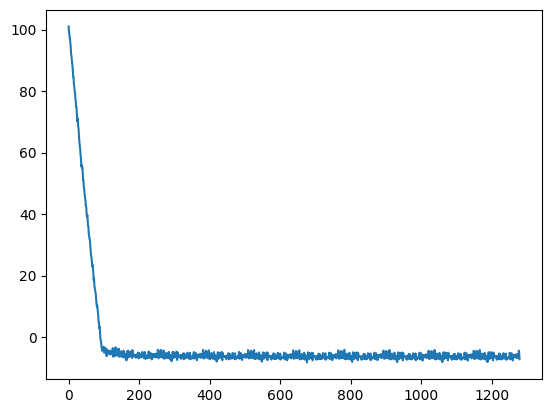

101 heads selected for predicate


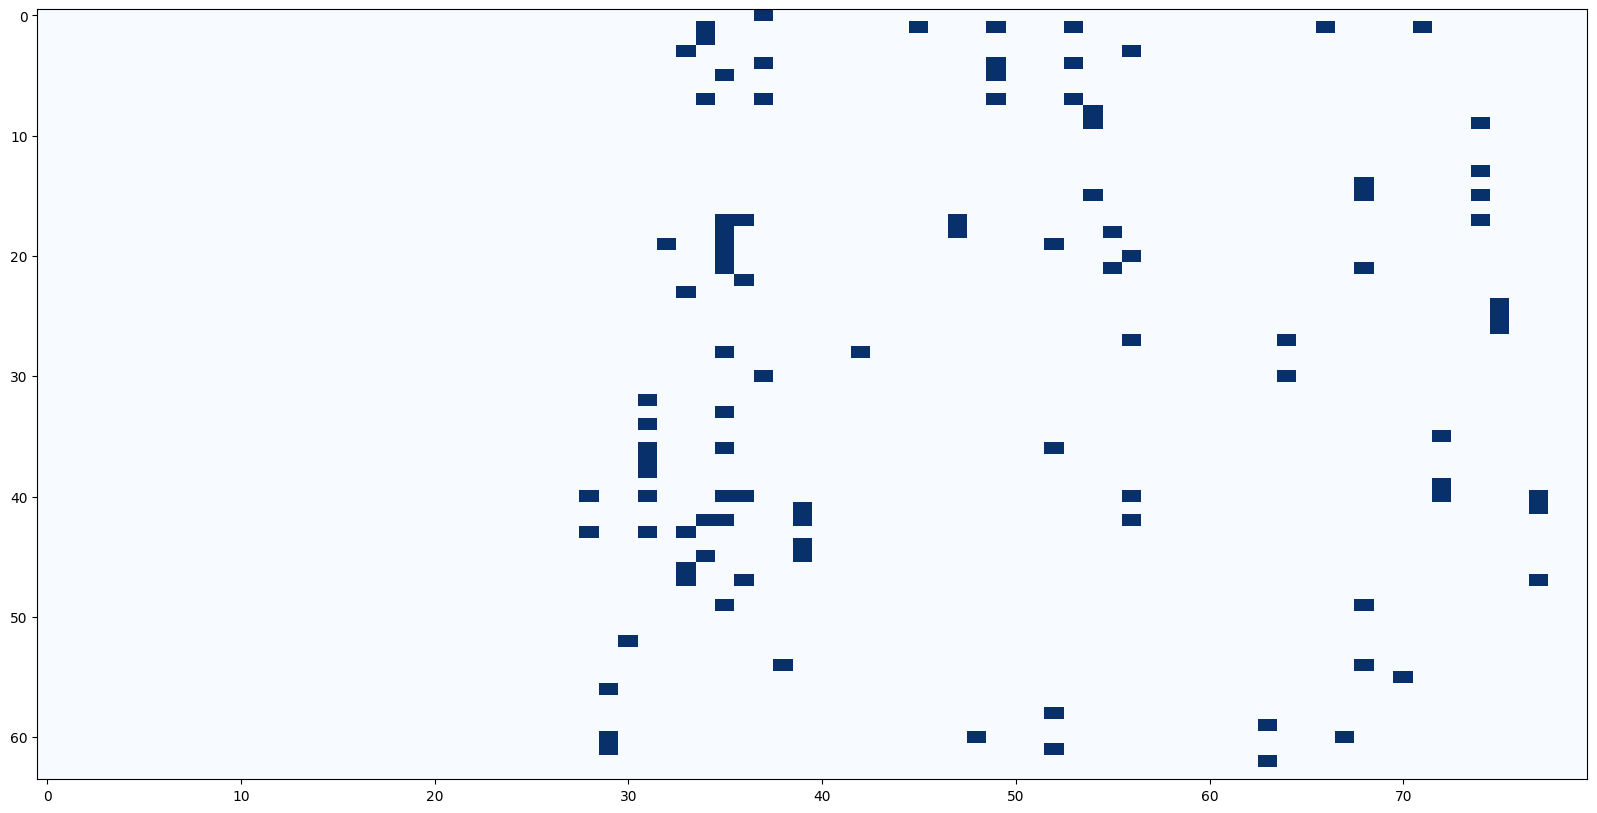

####################################################################################################
Processing pointer...
####################################################################################################


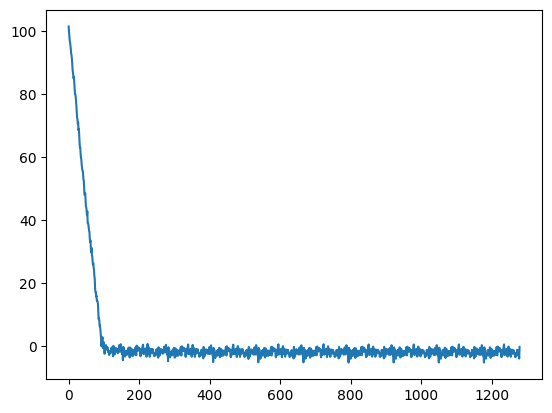

57 heads selected for pointer


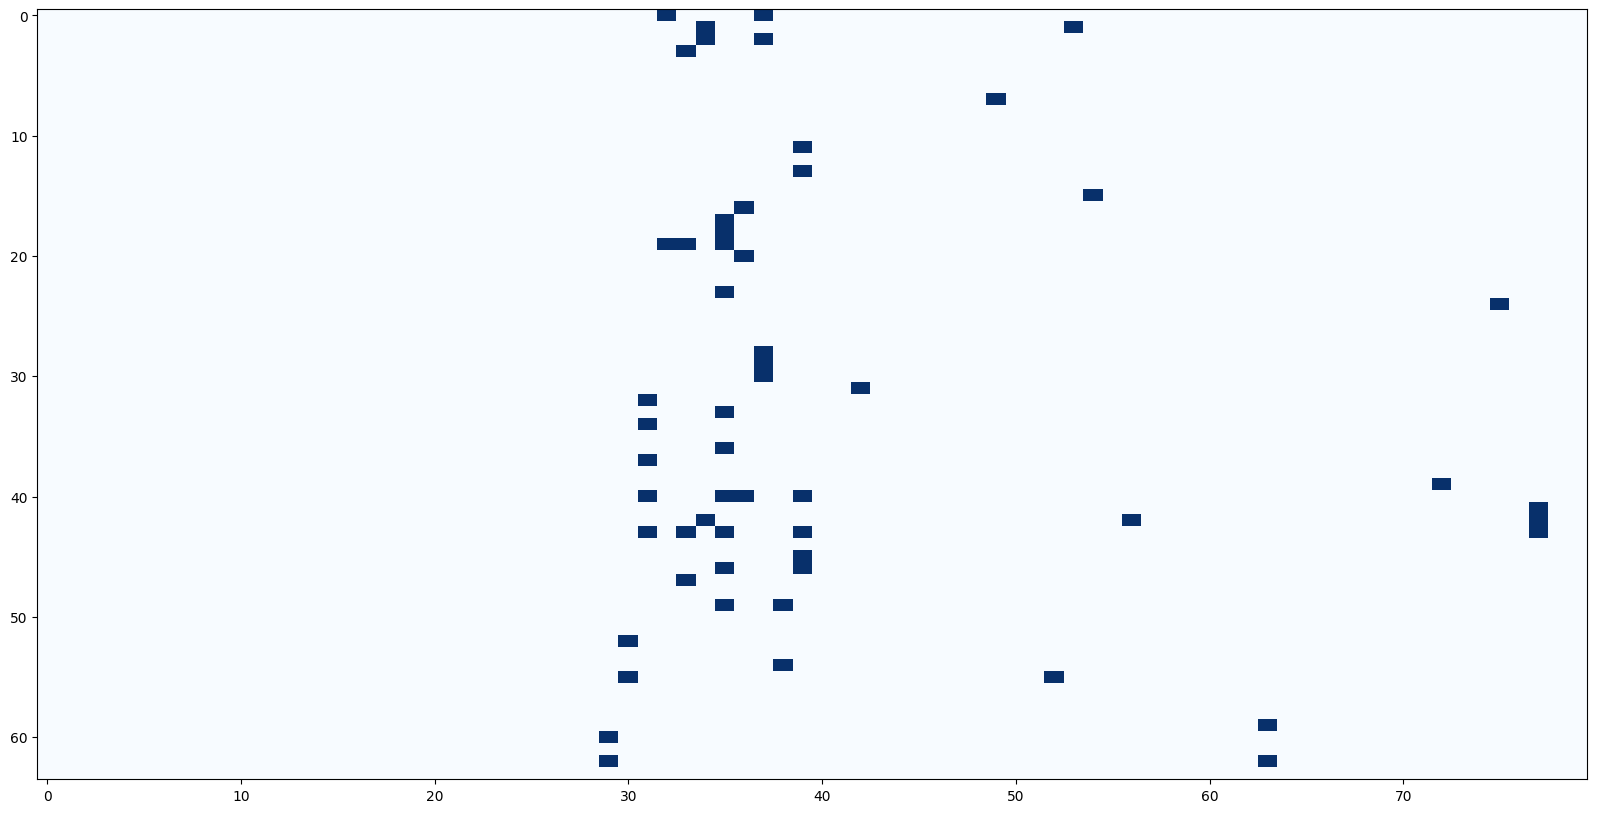

####################################################################################################
Processing latent_logit...
####################################################################################################


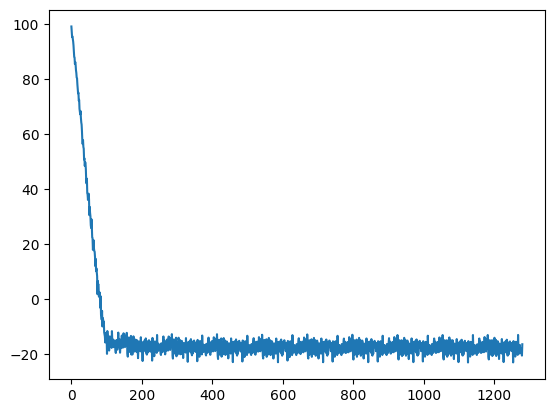

216 heads selected for latent_logit


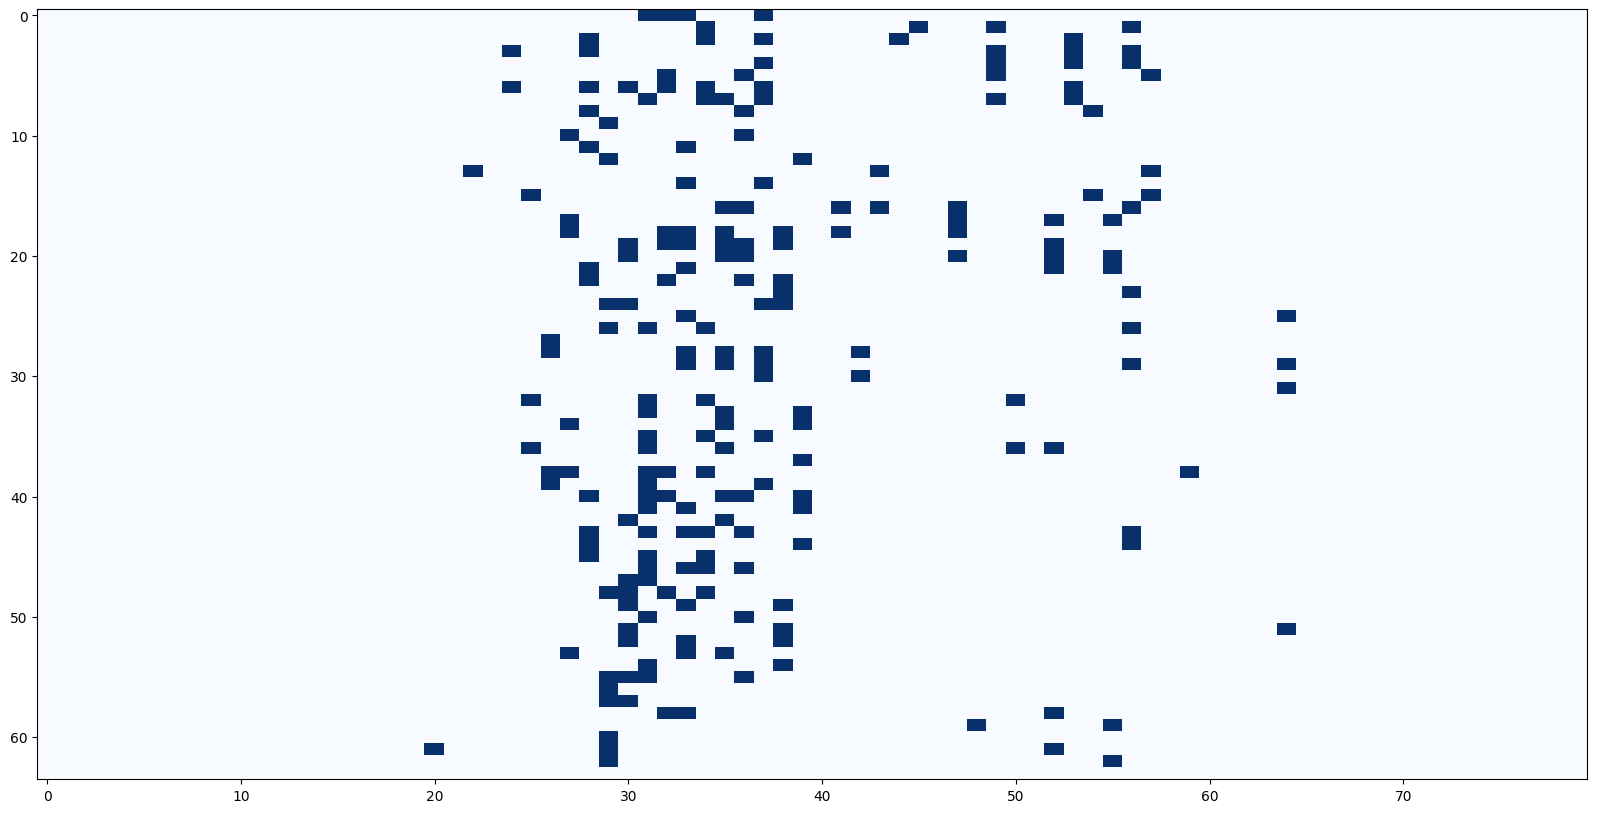

In [31]:
from matplotlib import pyplot as plt
import numpy as np

config = {
    "predicate": "distinct_options",
    "pointer": "ans_pointer",
    "latent_logit": "distinct_options"
}
heads_selected = {key: None for key in config.keys()}

for target_concept, folder_id in config.items():
    print("#"*100)
    print(f"Processing {target_concept}...")
    print("#"*100)
    root = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR,
        "selection/ov_contribution"
    )
    if target_concept == "latent_logit":
        root = os.path.join(
            root, "latent_logit"
        )
    optimized_path = os.path.join(
        root,
        model_key.split("/")[-1],
        folder_id,
        "select_one_mcq",
        "legacy",
        "epoch_10.npz"
    )
    optimization_results = np.load(optimized_path, allow_pickle=True)
    losses = optimization_results["losses"]
    plt.plot(losses)
    plt.show()

    plt.figure(figsize=(20, 10))
    optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
    # optimal_head_mask[52:, :] = 0.0

    plt.imshow(
        optimal_head_mask.T.numpy(),
        cmap="Blues",
        aspect="auto",
        vmin=0,
        vmax=1,
    )

    heads_selected[target_concept] = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
    heads_selected[target_concept] = [
        (layer_idx, head_idx) for layer_idx, head_idx in heads_selected[target_concept]
    ]
    print(len(heads_selected[target_concept]), "heads selected for", target_concept)
    plt.show()

2025-10-23 16:41:47 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-10-23 16:41:47 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-10-23 16:41:47 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-10-23 16:41:47 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.tt

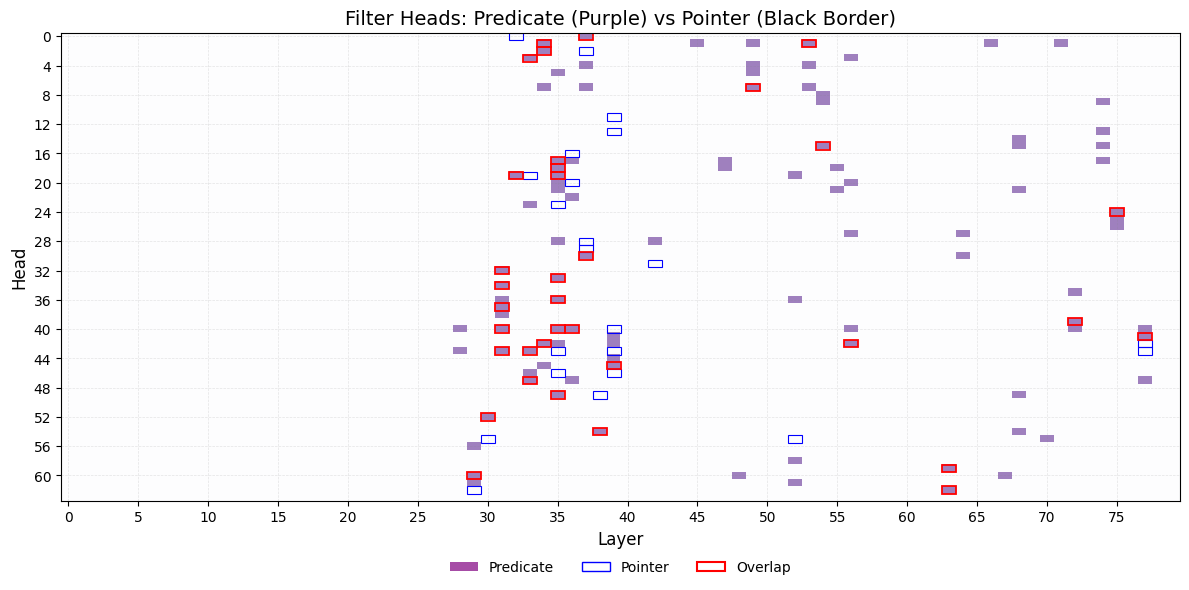

Total heads for predicate: 101
Total heads for pointer: 57
Overlapping heads: 35
Overlapping positions: [(29, 60), (30, 52), (31, 32), (31, 34), (31, 37), (31, 40), (31, 43), (32, 19), (33, 3), (33, 43), (33, 47), (34, 1), (34, 2), (34, 42), (35, 17), (35, 18), (35, 19), (35, 33), (35, 36), (35, 40), (35, 49), (36, 40), (37, 0), (37, 30), (38, 54), (39, 45), (49, 7), (53, 1), (54, 15), (56, 42), (63, 59), (63, 62), (72, 39), (75, 24), (77, 41)]


In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

colors = {
    "predicate": "Purples",
    "pointer": "Blues",
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Start with base visualization for predicate heads
predicate_mask = np.zeros((mt.config.num_attention_heads, mt.n_layer))
for layer_idx, head_idx in heads_selected["predicate"]:
    predicate_mask[head_idx, layer_idx] = 1.0

# Plot predicate heads as colored heatmap
im = ax.imshow(
    predicate_mask,
    cmap=colors["predicate"],
    aspect="auto",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    alpha=0.5,
)

# Find overlapping heads
overlapping_heads = []
for head in heads_selected["predicate"]:
    if head in heads_selected["pointer"]:
        overlapping_heads.append(head)

# Draw dark borders for pointer heads (excluding overlaps)
for layer_idx, head_idx in heads_selected["pointer"]:
    if (layer_idx, head_idx) not in overlapping_heads:
        rect = mpatches.Rectangle(
            (layer_idx - 0.5, head_idx - 0.5),
            1,
            1,
            fill=False,
            edgecolor="blue",
            linewidth=0.8,
        )
        ax.add_patch(rect)

# Draw thicker red borders for overlapping heads
for layer_idx, head_idx in overlapping_heads:
    rect = mpatches.Rectangle(
        (layer_idx - 0.5, head_idx - 0.5),
        1,
        1,
        fill=False,
        edgecolor="red",
        linewidth=1.3,
    )
    ax.add_patch(rect)

# Add labels and formatting
ax.set_xlabel("Layer", fontsize=12)
ax.set_ylabel("Head", fontsize=12)
ax.set_title("Filter Heads: Predicate (Purple) vs Pointer (Black Border)", fontsize=14)

# Add grid for clarity
ax.set_xticks(np.arange(0, mt.n_layer, 5))
ax.set_yticks(np.arange(0, mt.config.num_attention_heads, 4))
ax.grid(True, alpha=0.2, linestyle="--", color="gray", linewidth=0.5)

# Create custom legend
legend_elements = [
    mpatches.Patch(facecolor="purple", alpha=0.7, label="Predicate"),
    mpatches.Patch(facecolor="white", edgecolor="blue", linewidth=1, label="Pointer"),
    mpatches.Patch(facecolor="white", edgecolor="red", linewidth=1.5, label="Overlap"),
]
ax.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=10,
    frameon=False,
)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Total heads for predicate: {len(heads_selected['predicate'])}")
print(f"Total heads for pointer: {len(heads_selected['pointer'])}")
print(f"Overlapping heads: {len(overlapping_heads)}")
if overlapping_heads:
    print(f"Overlapping positions: {overlapping_heads}")

In [78]:
from src.selection.data import MCQify_sample

sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)
sample = MCQify_sample(sample = sample, tokenizer = mt, start_from="p")

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

fruit >> ['Orange', 'Strawberry', 'Mango', 'Watermelon', 'Blueberry', 'Apple', 'Grape', 'Raspberry', 'Pineapple', 'Plum', 'Kiwi', 'Pear', 'Banana', 'Peach', 'Cherry']
p. Marker
q. Zebra
r. Saxophone
s. Surfboard
t. Scooter
u. Raspberry
Which among these objects mentioned above is a fruit?
Answer: >> " u"


In [79]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(),
    options=sample.options,
    mt=mt,
    heads=heads_selected["predicate"],
    # heads=heads_selected["pointer"],
    start_from=1
)

2025-10-23 17:30:56 src.selection.functional DEBUG    Predictions: ['" u"[577] (p=0.863, logit=22.000)', '" Option"[7104] (p=0.049, logit=19.125)', '" Raspberry"[48665] (p=0.030, logit=18.625)', '" ("[320] (p=0.026, logit=18.500)', '" The"[578] (p=0.005, logit=16.875)']
2025-10-23 17:30:56 src.selection.functional INFO     Combined attention matrix for all heads


## Apply Logit Lens on the OV contribution

In [70]:
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
import copy
import baukit
from src.functional import patch_with_baukit, interpret_logits, get_hs
from src.selection.utils import get_first_token_id
from src.tokens import prepare_input

# HEADS = copy.deepcopy(heads_selected)
HEADS = heads_selected["latent_logit"]
# HEADS = heads_selected["pointer"]
# HEADS = heads_selected["predicate"]

HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx <= 52]

tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)

mt.reset_forward()
mt.set_attn_implementation("sdpa")

layers_to_heads = {}
for layer_idx, head_idx in HEADS:
    if layer_idx not in layers_to_heads:
        layers_to_heads[layer_idx] = []
    layers_to_heads[layer_idx].append(head_idx)

head_contributions = {}
for layer_idx, head_indices in layers_to_heads.items():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    head_contributions[layer_idx] = {}

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=head_indices,
            store_head_contributions=head_contributions[layer_idx],
        ),
        attn_block,
    )

logit_location = (mt.lm_head_name, -1)
logit = get_hs(
    mt=mt,
    input=tokenized,
    locations = logit_location,
    return_dict=False
)

mt.reset_forward()
mt.set_attn_implementation("eager")

pred = interpret_logits(
    logits=logit,
    tokenizer=mt.tokenizer,
)
pred

2025-10-23 17:28:09 src.hooking.llama_attention WARNING  model.layers.34.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=25.5, __attn_output.norm().item()=25.5


[PredictedToken(token=' r', prob=0.609375, logit=20.625, token_id=436, metadata=None),
 PredictedToken(token=' Option', prob=0.1201171875, logit=19.0, token_id=7104, metadata=None),
 PredictedToken(token=' Cherry', prob=0.09375, logit=18.75, token_id=45805, metadata=None),
 PredictedToken(token=' (', prob=0.08251953125, logit=18.625, token_id=320, metadata=None),
 PredictedToken(token=' Among', prob=0.02685546875, logit=17.5, token_id=22395, metadata=None)]

In [71]:
from src.functional import logit_lens
from src.selection.data import get_options_for_answer

# head_contrib = head_contributions[35][19][:, -1, :]
head_contrib = []
for layer_idx, head_idx in HEADS:
    head_contrib.append(
        head_contributions[layer_idx][head_idx][:, -1, :].squeeze().cuda()
    )

head_contrib = torch.stack(head_contrib).sum(dim=0)

logit_lens(
    mt=mt,
    h=head_contrib,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ],
    k=20
)

# head_contrib.shape

([PredictedToken(token=' Pierce', prob=0.00701904296875, logit=8.125, token_id=50930, metadata=None),
  PredictedToken(token=' passive', prob=0.004119873046875, logit=7.59375, token_id=28979, metadata=None),
  PredictedToken(token=' ゝ', prob=0.003997802734375, logit=7.5625, token_id=116401, metadata=None),
  PredictedToken(token=' Mata', prob=0.003021240234375, logit=7.28125, token_id=89454, metadata=None),
  PredictedToken(token='-caret', prob=0.0029296875, logit=7.25, token_id=84022, metadata=None),
  PredictedToken(token=' chains', prob=0.00274658203125, logit=7.1875, token_id=27271, metadata=None),
  PredictedToken(token=' dri', prob=0.002655029296875, logit=7.15625, token_id=50511, metadata=None),
  PredictedToken(token=' Dalton', prob=0.002349853515625, logit=7.03125, token_id=72554, metadata=None),
  PredictedToken(token='heet', prob=0.0022735595703125, logit=7.0, token_id=3759, metadata=None),
  PredictedToken(token='942', prob=0.0022125244140625, logit=6.96875, token_id=20249,

In [72]:
from src.functional import patchscope

patchscope(
    mt=mt,
    h=head_contrib,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ],
    patch_layers=[mt.layer_name_format.format(layer_idx) for layer_idx in range(5, 6)],
    k=20
)

2025-10-23 17:28:28 src.functional DEBUG     copy > copy
 Cat > Cat
 Java > Java
 transistor > transistor
 python > python
 Leonardo DiCaprio > Leonardo DiCaprio
 The Lion King > The Lion King
 Washington D.C. > Washington D.C.
 Mount Everest > Mount Everest
 computer > computer
 x >
2025-10-23 17:28:28 src.functional WARNING  placeholder='x' does not end with placeholder_ends=' x' | placeholder_idx=58


([PredictedToken(token=' ', prob=0.7421875, logit=14.8125, token_id=220, metadata=None),
  PredictedToken(token=' q', prob=0.019775390625, logit=11.1875, token_id=2874, metadata=None),
  PredictedToken(token=' \n', prob=0.01275634765625, logit=10.75, token_id=720, metadata=None),
  PredictedToken(token=' n', prob=0.00994873046875, logit=10.5, token_id=308, metadata=None),
  PredictedToken(token=' p', prob=0.00994873046875, logit=10.5, token_id=281, metadata=None),
  PredictedToken(token=' o', prob=0.006805419921875, logit=10.125, token_id=297, metadata=None),
  PredictedToken(token=' π', prob=0.00469970703125, logit=9.75, token_id=52845, metadata=None),
  PredictedToken(token=' a', prob=0.0036468505859375, logit=9.5, token_id=264, metadata=None),
  PredictedToken(token=' -\n', prob=0.0032196044921875, logit=9.375, token_id=18722, metadata=None),
  PredictedToken(token=' x', prob=0.002838134765625, logit=9.25, token_id=865, metadata=None),
  PredictedToken(token=' Q', prob=0.00250244140

In [73]:
from src.functional import free_gpu_cache
del head_contributions
del head_contrib
free_gpu_cache()

In [74]:
sample.obj, sample.ans_token_id

('Cherry', 436)

## Just apply Logit Lens on the Latents

In [80]:
from src.tokens import prepare_input

def apply_logit_lens_per_layer(mt, sample):
    tokenized = prepare_input(tokenizer=mt.tokenizer, prompts=sample.prompt())
    track_tokens = {
        "object": get_first_token_id(name=sample.obj, tokenizer=mt.tokenizer, prefix=" "),
        "ans_tok": sample.ans_token_id,
    }
    hs = get_hs(
        mt=mt,
        input=tokenized,
        locations=[(layer_name, -1) for layer_name in mt.layer_names],
        return_dict=True,
    )

    interested_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ]

    layerwise_results = {}
    for layer_idx in range(mt.n_layer):
        layer_name = mt.layer_name_format.format(layer_idx)
        h = hs[(layer_name, -1)]
        logits, (ll_pred, ll_track) = logit_lens(mt=mt, h=h, interested_tokens=interested_tokens, return_logits=True)
        print(
            f"{layer_name} | {[f'{mt.tokenizer.decode(token_id)}({ll_track[token_id][0]} | {ll_track[token_id][1].logit:.2f})' for token_id in ll_track.keys()]} | {[str(pred) for pred in ll_pred]}"
        )
        layerwise_results[layer_idx] = {
            "ll_pred": ll_pred,
            "ll_track": ll_track,
            "logits": logits
        }

    return {
        "sample": sample,
        "track_tokens": track_tokens,
        "layerwise_results": layerwise_results,
    }

ll_result_for_sample = apply_logit_lens_per_layer(mt=mt, sample=sample)

model.layers.0 | [' Surf(8294 | 1.93)', ' Raspberry(14707 | 1.45)', ' q(17351 | 1.30)', ' r(41267 | 0.35)', ' s(41134 | 0.35)', ' p(45918 | 0.20)', ' Marker(63094 | -0.30)', ' t(64855 | -0.36)', ' u(79796 | -0.80)', ' Sco(89871 | -1.12)', ' Z(95391 | -1.31)', ' Sax(97241 | -1.38)'] | ['"ogo"[24404] (p=0.002, logit=6.438)', '" NotImplemented"[22273] (p=0.002, logit=6.312)', '" Salv"[32066] (p=0.002, logit=6.219)', '" Oswald"[90450] (p=0.001, logit=5.969)', '" childhood"[20587] (p=0.001, logit=5.875)']
model.layers.1 | [' Raspberry(6555 | 2.16)', ' Surf(23561 | 0.98)', ' s(26335 | 0.86)', ' r(37947 | 0.42)', ' q(45485 | 0.17)', ' p(52874 | -0.06)', ' t(67964 | -0.52)', ' Marker(69026 | -0.55)', ' Sco(69507 | -0.56)', ' u(70123 | -0.58)', ' Sax(76240 | -0.77)', ' Z(77747 | -0.82)'] | ['"ogo"[24404] (p=0.003, logit=6.719)', '"럴"[121408] (p=0.003, logit=6.688)', '" rem"[1323] (p=0.002, logit=6.500)', '"abi"[26140] (p=0.002, logit=6.375)', '" Oswald"[90450] (p=0.002, logit=6.344)']
model.lay

In [ ]:
import random
from tqdm.auto import tqdm

results = []
limit = 64

for _ in tqdm(range(limit)):
    sample = select_task.get_random_sample(
        mt = mt,
        option_style=OPTION_STYLE,
        prompt_template_idx=prompt_template_idx,
        # category="fruit",
        filter_by_lm_prediction=True,
        n_distractors=random.choice(range(2, 6)),
    )
    sample = MCQify_sample(sample = sample, tokenizer = mt, start_from="p")
    print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')
    result = apply_logit_lens_per_layer(mt=mt, sample=sample)
    results.append(result)


  0%|          | 0/6 [00:00<?, ?it/s]

building >> ['Skyscraper', 'Museum', 'Library', 'Warehouse', 'Mall', 'Mosque', 'School', 'Stadium', 'Theater', 'Church', 'House', 'Apartment', 'Temple', 'Hospital', 'Factory']
a. Onion
b. Library
c. Watermelon
Which among these objects mentioned above is a building?
Answer: >> " b"
model.layers.0 | [' c(17956 | 1.30)', ' b(27592 | 0.87)', ' Onion(39841 | 0.42)', ' Water(83827 | -0.89)', ' a(100382 | -1.45)', ' Library(109612 | -1.86)'] | ['"ogo"[24404] (p=0.002, logit=6.406)', '" NotImplemented"[22273] (p=0.002, logit=6.188)', '" Salv"[32066] (p=0.001, logit=6.094)', '"럴"[121408] (p=0.001, logit=6.031)', '"abi"[26140] (p=0.001, logit=5.938)']
model.layers.1 | [' b(5874 | 2.27)', ' c(19213 | 1.23)', ' Water(58019 | -0.18)', ' a(73199 | -0.64)', ' Onion(77494 | -0.77)', ' Library(91061 | -1.22)'] | ['"럴"[121408] (p=0.003, logit=6.750)', '"ogo"[24404] (p=0.002, logit=6.531)', '"abi"[26140] (p=0.002, logit=6.438)', '" rem"[1323] (p=0.002, logit=6.375)', '" Oswald"[90450] (p=0.002, logit=6.

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6dc0f57a50>>
Traceback (most recent call last):
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


model.layers.41 | [' d(132 | 4.72)', ' c(330 | 4.12)', ' e(1258 | 3.12)', ' b(2221 | 2.70)', ' a(2612 | 2.56)', ' Apple(10896 | 1.33)', ' Sk(21050 | 0.64)', ' f(41814 | -0.27)', ' Red(41925 | -0.27)', ' Clar(63870 | -1.02)', ' Desk(75985 | -1.43)', ' Harmon(117265 | -3.38)'] | ['" none"[7000] (p=0.609, logit=13.500)', '" NONE"[43969] (p=0.106, logit=11.750)', '" option"[3072] (p=0.037, logit=10.688)', '"None"[4155] (p=0.021, logit=10.125)', '" None"[2290] (p=0.017, logit=9.938)']
model.layers.42 | [' d(40 | 5.81)', ' c(498 | 3.88)', ' e(1802 | 2.88)', ' b(2272 | 2.70)', ' a(4224 | 2.19)', ' Sk(17968 | 0.82)', ' Apple(26358 | 0.38)', ' Red(39000 | -0.15)', ' f(47209 | -0.46)', ' Desk(61422 | -0.93)', ' Clar(63526 | -1.00)', ' Harmon(120316 | -3.69)'] | ['" none"[7000] (p=0.469, logit=12.812)', '" option"[3072] (p=0.072, logit=10.938)', '" NONE"[43969] (p=0.067, logit=10.875)', '" correct"[4495] (p=0.022, logit=9.750)', '"None"[4155] (p=0.017, logit=9.500)']
model.layers.43 | [' d(23 | 6

In [87]:
# results = [ll_result_for_sample]

from src.trace import rank_reward

scores = {token_type: [] for token_type in results[0]["track_tokens"].keys()}
causality = []
for result in results:
    for token_type in scores.keys():
        layerwise_scores = []
        token_id = result["track_tokens"][token_type]
        for layer_idx in range(mt.n_layer):
            # score = result["layerwise_results"][layer_idx]["ll_track"][token_id][1].logit
            score = rank_reward(
                rank=result["layerwise_results"][layer_idx]["ll_track"][token_id][0],
                k=500
            )
            layerwise_scores.append(score)
        layerwise_scores = np.array(layerwise_scores)
        scores[token_type].append(layerwise_scores)

2025-10-23 17:37:33 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2025-10-23 17:37:33 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2025-10-23 17:37:33 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


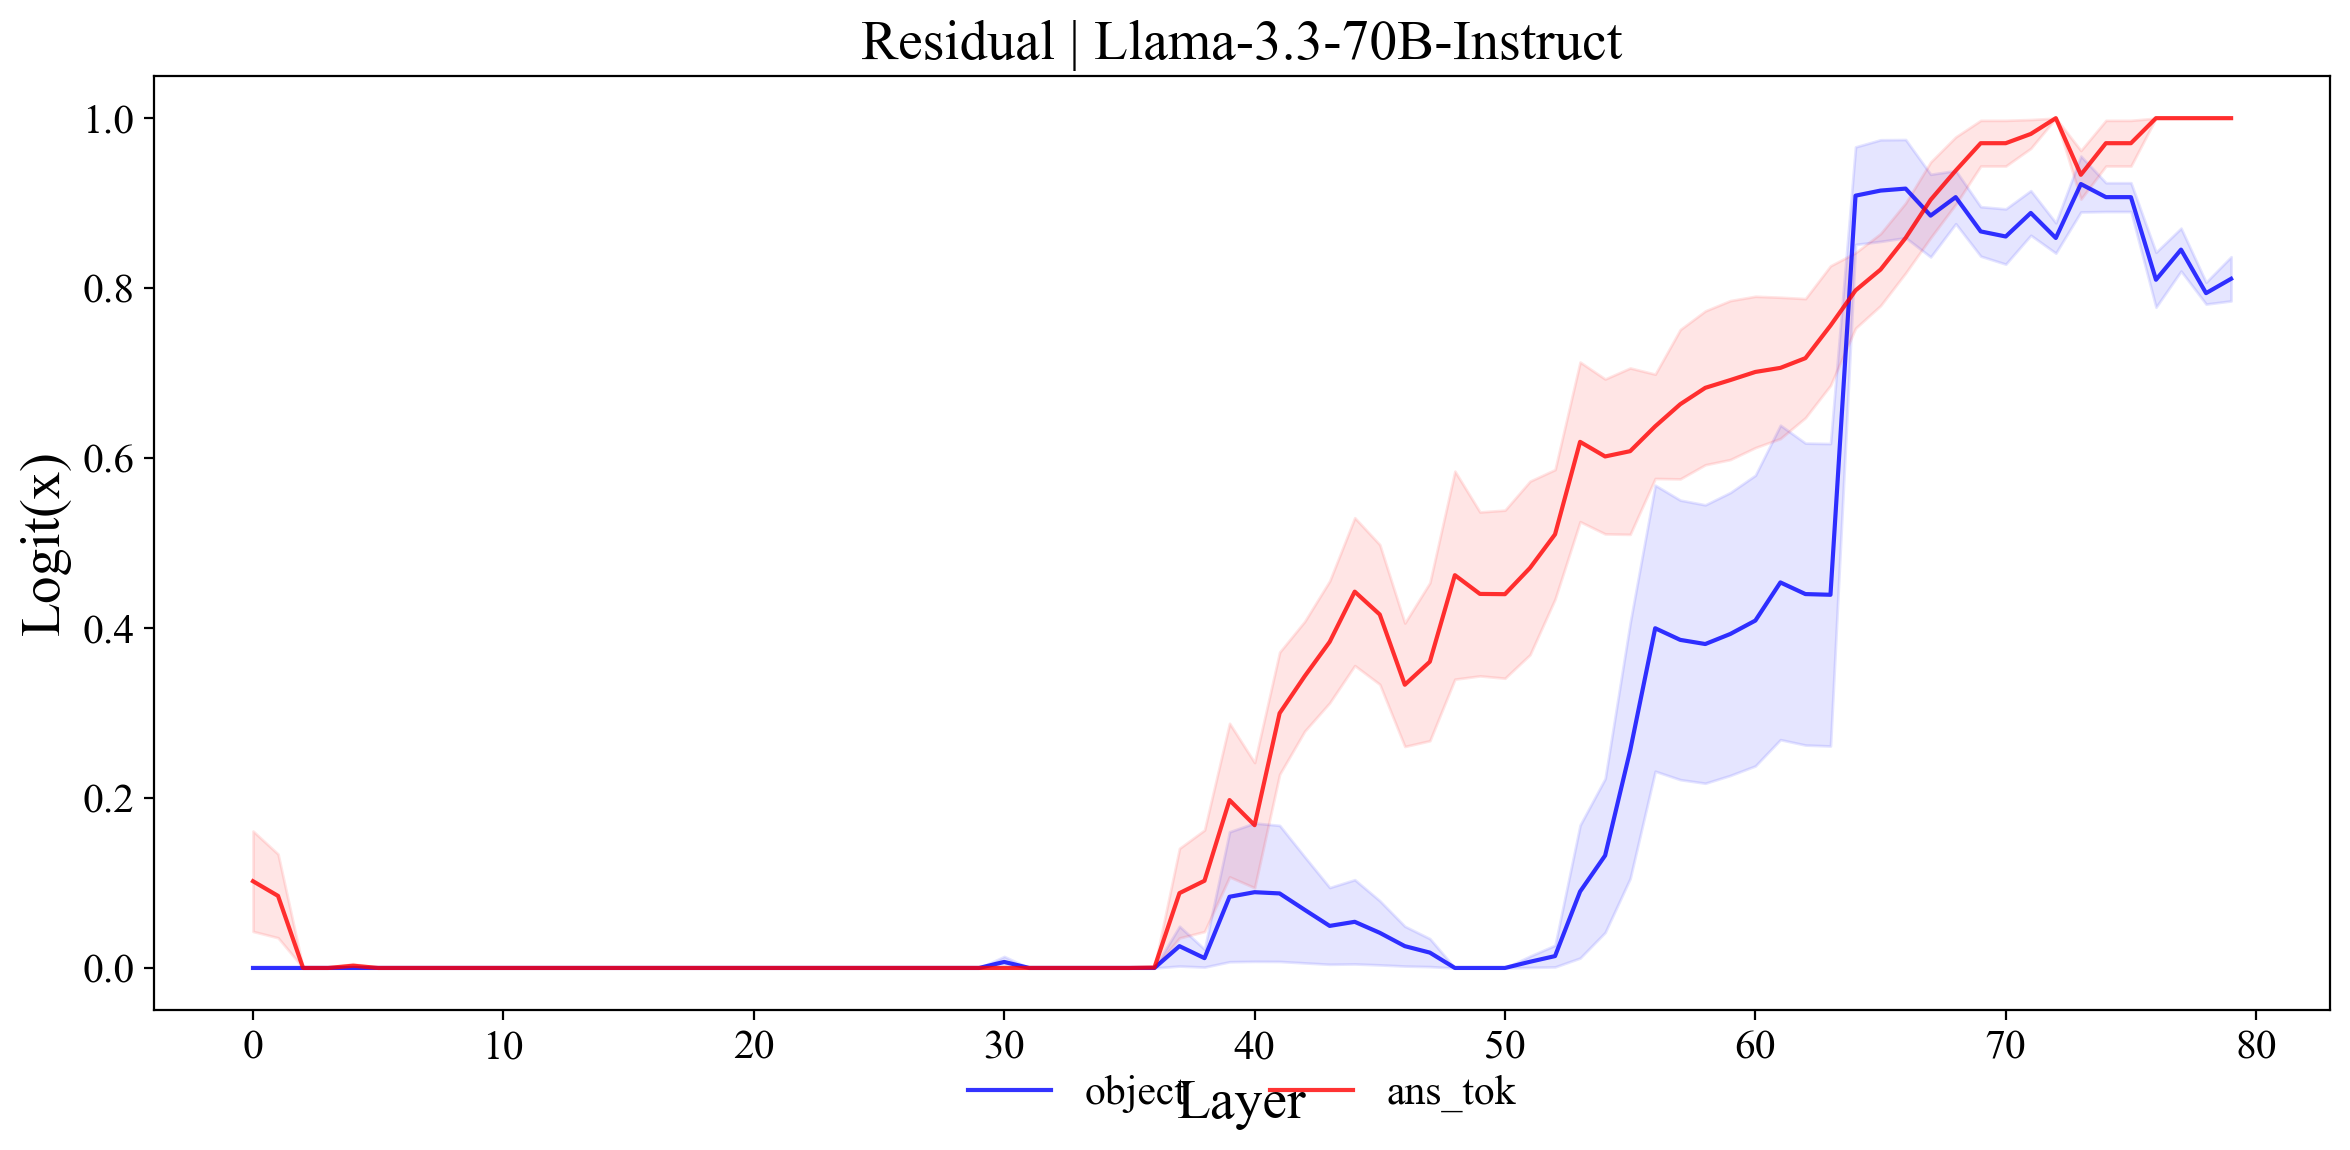

In [88]:
import numpy as np

# Create a figure with a single subplot
from matplotlib import pyplot as plt

plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 35

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
colors = {
    "object": "blue",
    "ans_tok": "red",
}

# Plot logits on the panel
lines = []
for token_type, layerwise_scores_list in scores.items():
    mean_scores = np.mean(layerwise_scores_list, axis=0)
    sterr_scores = np.std(layerwise_scores_list, axis=0) / np.sqrt(
        len(layerwise_scores_list)
    )
    line, = ax1.plot(mean_scores, label=f"{token_type}", alpha=0.8, color=colors[token_type])
    ax1.fill_between(
        range(len(mean_scores)),
        mean_scores - sterr_scores,
        mean_scores + sterr_scores,
        alpha=0.1,
        color=colors[token_type],
    )
    lines.append(line)

ax1.set_xlabel("Layer")
ax1.set_ylabel("Logit(x)")
ax1.set_title(f"Residual | {mt.name.split('/')[-1]}")

# Place the legend horizontally on top of the panel
ax1.legend(
    handles=lines,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(scores),
    frameon=False,
    fontsize="medium"
)

plt.tight_layout()
save_dir = os.path.join("figures", model_key.split("/")[-1], "logit_lens_contribution")
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, f"template_{prompt_template_idx}_mcq.pdf"), bbox_inches="tight")

## Patching to check effects

In [138]:
from src.selection.data import CounterFactualSamplePair
import random
from src.utils.typing import PathLike
from src.selection.data import SelectionSample, get_first_token_id

def load_dataset(
    path: PathLike, limit: int, prefix="", min_seq_len=4
) -> list[SelectionSample, SelectionSample]:
    sample_files = [
        os.path.join(path, f) for f in os.listdir(path) if f.endswith(".json")
    ]
    logger.info(f"Found {len(sample_files)} sample files")

    # prefix = "Recall the nationality of these people:\n"
    # prefix = "Recall which country these landmarks are located in:\n"
    # prefix = "Think about how these words sound when you say them aloud:\n"

    random.shuffle(sample_files)
    dataset = []
    for sample_file in sample_files:
        if len(dataset) >= limit:
            break
        with open(sample_file, "r") as f:
            cf_pair_data = json.load(f)
        cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
        if len(cf_pair.patch_sample.options) < min_seq_len:
            continue
        # cf_pair.patch_sample.default_option_style = "bulleted"
        # cf_pair.clean_sample.default_option_style = "bulleted"

        cf_pair.patch_sample = MCQify_sample(sample = cf_pair.patch_sample, tokenizer = mt, start_from="a")
        cf_pair.patch_sample.ans_token_id = get_first_token_id(chr(cf_pair.patch_sample.obj_idx + ord(cf_pair.patch_sample.option_label_start_from)), tokenizer = mt.tokenizer, prefix=" ")
        cf_pair.clean_sample = MCQify_sample(sample = cf_pair.clean_sample, tokenizer = mt, start_from="p")
        cf_pair.clean_sample.ans_token_id = get_first_token_id(chr(cf_pair.clean_sample.obj_idx + ord(cf_pair.clean_sample.option_label_start_from)), tokenizer = mt.tokenizer, prefix=" ")
        pred_obj_idx = cf_pair.clean_sample.metadata["track_type_obj_idx"]
        cf_pair.clean_sample.metadata["track_type_obj_token_id"] = get_first_token_id(
            name=chr(ord(cf_pair.clean_sample.option_label_start_from) + pred_obj_idx),
            tokenizer=mt.tokenizer,
            prefix=" "
        )

        cf_pair.clean_sample.prompt_template = (
            prefix + cf_pair.clean_sample.prompt_template
        )
        cf_pair.patch_sample.prompt_template = (
            prefix + cf_pair.patch_sample.prompt_template
        )
        dataset.append((cf_pair.clean_sample, cf_pair.patch_sample))

    return dataset

data_type = "objects"
# data_type = "profession"
validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_task.task_name,
    data_type,
)
validation_set = load_dataset(
    path=validation_samples_load_path, limit=512, prefix=""
)
len(validation_set)

2025-10-20 17:07:23 __main__ INFO     Found 1024 sample files


512

In [154]:
destination_sample, source_sample = validation_set[37]
print("Source:", source_sample.prompt(), ">>", source_sample.obj, ">>", mt.tokenizer.decode([source_sample.ans_token_id]))
print("Destination:", destination_sample.prompt(), ">>", destination_sample.obj, ">>", mt.tokenizer.decode([destination_sample.ans_token_id]))
print(
    f"target: {destination_sample.metadata['track_type_obj']} | \"{mt.tokenizer.decode(destination_sample.metadata['track_type_obj_token_id'])}\""
)

Source: a. Cherry
b. Mall
c. Shirt
d. Speaker
Which among these objects mentioned above is a electronics?
Answer: >> Speaker >>  d
Destination: p. Phone
q. Warehouse
r. Plum
s. Carrot
Which among these objects mentioned above is a building?
Answer: >> Warehouse >>  q
target: Phone | " p"


In [155]:
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
import copy
import baukit
from src.functional import patch_with_baukit, interpret_logits, get_hs
from src.selection.utils import get_first_token_id
from src.tokens import prepare_input
from src.utils.typing import TokenizerOutput
from src.attention import visualize_attn_matrix
from typing import Optional


def get_head_contributions(
    mt: ModelandTokenizer,
    heads: list[tuple[int, int]],
    tokenized: TokenizerOutput,
    visualize_attn: bool = False,
    freeze_attn_contributions: Optional[dict[int, torch.Tensor]] = None,
):
    mt.reset_forward()
    mt.set_attn_implementation("sdpa")

    layers_to_heads = {}
    for layer_idx, head_idx in heads:
        if layer_idx not in layers_to_heads:
            layers_to_heads[layer_idx] = []
        layers_to_heads[layer_idx].append(head_idx)

    head_contributions = {}
    attention_patterns = {}
    for layer_idx, head_indices in layers_to_heads.items():
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        head_contributions[layer_idx] = {}
        attention_patterns[layer_idx] = {}

        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                save_attn_for=head_indices,
                store_head_contributions=head_contributions[layer_idx],
                store_attn_matrices=attention_patterns[layer_idx],
                freeze_attn_contributions=freeze_attn_contributions.get(layer_idx, None) if freeze_attn_contributions is not None else None,
            ),
            attn_block,
        )

    output = mt._model(**tokenized)

    if visualize_attn:
        attn_matrix = []
        for layer_idx in attention_patterns:
            for head_idx in attention_patterns[layer_idx]:
                attn_matrix.append(
                    attention_patterns[layer_idx][head_idx].cpu()
                )

        attn_matrix = torch.stack(attn_matrix).squeeze()
        if attn_matrix.dim() == 3:
            attn_matrix = attn_matrix.mean(dim=0)

        visualize_attn_matrix(
            attn_matrix=attn_matrix,
            tokens=[
                mt.tokenizer.decode(t) for t in tokenized["input_ids"][0]
            ],
        )

    mt.reset_forward()
    mt.set_attn_implementation("eager")

    return head_contributions, output

In [156]:
print(mt.model.layers[35].self_attn.source)

                             * def forward(
                             0     self,
                             1     hidden_states: torch.Tensor,
                             2     position_embeddings: tuple[torch.Tensor, torch.Tensor],
                             3     attention_mask: Optional[torch.Tensor],
                             4     past_key_value: Optional[Cache] = None,
                             5     cache_position: Optional[torch.LongTensor] = None,
                             6     **kwargs: Unpack[TransformersKwargs],
                             7 ) -> tuple[torch.Tensor, torch.Tensor]:
                             8     input_shape = hidden_states.shape[:-1]
                             9     hidden_shape = (*input_shape, -1, self.head_dim)
                            10 
 self_q_proj_0           -> 11     query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
 view_0                  ->  +     ...
 transpose_0             ->  +     ...


In [157]:
# from src.functional import get_module_nnsight
# from src.hooking.llama_attention import attn_per_head
# from src.utils.typing import TokenizerOutput
# from typing import Optional

# def get_head_contributions_fast(
#     mt: ModelandTokenizer,
#     heads: list[tuple[int, int]],
#     tokenized: TokenizerOutput,
#     visualize_attn: bool = False,
#     freeze_attn_contributions: Optional[dict[int, torch.Tensor]] = None,
# ):
#     mt.reset_forward()
#     mt.set_attn_implementation("eager")

#     layers_to_heads = {}
#     for layer_idx, head_idx in heads:
#         if layer_idx not in layers_to_heads:
#             layers_to_heads[layer_idx] = []
#         layers_to_heads[layer_idx].append(head_idx)

#     head_contributions = {}
#     attention_patterns = {}

#     intermediate_attn_outputs = {}
#     with mt.trace(tokenized, output_attentions=True) as tr:
#         for layer_idx in layers_to_heads.keys():
#             attn_block_name = mt.attn_module_name_format.format(layer_idx)
#             print(f"{layer_idx=} | {attn_block_name}")
#             attn_block = get_module_nnsight(mt, attn_block_name)
#             # intermediate_attn_outputs[layer_idx] = attn_block.source.attention_interface_0.output.save()
#             # attn_output, attn_weights = intermediate_attn_outputs[layer_idx]
#             attention_interface_0 = mt.model.layers[layer_idx].self_attn.source.attention_interface_0.output.save()
#             attn_output = attention_interface_0[0].save()
#             attn_weights = attention_interface_0[1].save()
#             intermediate_attn_outputs[layer_idx] = (attn_output, attn_weights)
#             # head_contributions[layer_idx] = {}
#             # attention_patterns[layer_idx] = {}

#             # per_head_attn = attn_per_head(
#             #     o_proj=baukit.get_module(mt._model, f"{attn_block_name}.o_proj"),
#             #     attn_output=attn_output,
#             #     freeze_attn_contributions=freeze_attn_contributions.get(layer_idx, None) if freeze_attn_contributions is not None else None,
#             # )
#             # for head_idx in head_indices:
#             #     head_contributions[layer_idx][head_idx] = per_head_attn[:, head_idx, :, :]
#             #     attention_patterns[layer_idx][head_idx] = attn_weights[:, head_idx, :, :]

#         output = mt.output.save()


#     # for layer_idx, head_indices in layers_to_heads.items():
#     #     attn_block_name = mt.attn_module_name_format.format(layer_idx)
#     #     attn_output = intermediate_attn_outputs[layer_idx]
#     #     head_contributions[layer_idx] = {}
#     #     attention_patterns[layer_idx] = {}

#     #     per_head_attn = attn_per_head(
#     #         o_proj=baukit.get_module(mt._model, f"{attn_block_name}.o_proj"),
#     #         attn_output=attn_output
#     #     )
#     #     for head_idx in head_indices:
#     #         head_contributions[layer_idx][head_idx] = per_head_attn[:, head_idx, :, :]



#     if visualize_attn:
#         attn_matrix = []
#         for layer_idx in attention_patterns:
#             for head_idx in attention_patterns[layer_idx]:
#                 attn_matrix.append(
#                     attention_patterns[layer_idx][head_idx].cpu()
#                 )

#         attn_matrix = torch.stack(attn_matrix).squeeze()
#         if attn_matrix.dim() == 3:
#             attn_matrix = attn_matrix.mean(dim=0)

#         visualize_attn_matrix(
#             attn_matrix=attn_matrix,
#             tokens=[
#                 mt.tokenizer.decode(t) for t in tokenized["input_ids"][0]
#             ],
#         )

#     mt.reset_forward()
#     mt.set_attn_implementation("eager")

#     return head_contributions, output

In [158]:
from src.selection.data import get_options_for_answer, get_first_token_id

get_head_contribution_interface = get_head_contributions
# get_head_contribution_interface = get_head_contributions_fast

source_tokenized = prepare_input(prompts=source_sample.prompt(), tokenizer=mt.tokenizer)
source_ov, source_output = get_head_contribution_interface(
    mt=mt,
    heads=heads_selected["predicate"],
    tokenized=source_tokenized,
    visualize_attn=True,
)
source_pred, source_track = interpret_logits(
    logits=source_output.logits[:, -1, :],
    tokenizer=mt.tokenizer,
    interested_tokens=list(
        set(
            [
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(source_sample) + source_sample.options
            ]
        )
    ),
)
print(f"source_pred: {[str(pred) for pred in source_pred]}")
print(f"Source track: {[str(pred) for tok_id, (rank, pred) in source_track.items()]}")

destination_tokenized = prepare_input(
    prompts=destination_sample.prompt(), tokenizer=mt.tokenizer
)
destination_ov, destination_output = get_head_contribution_interface(
    mt=mt,
    heads=heads_selected["predicate"],
    tokenized=destination_tokenized,
    visualize_attn=True,
)
destination_pred, destination_track = interpret_logits(
    logits=destination_output.logits[:, -1, :],
    tokenizer=mt.tokenizer,
    interested_tokens=list(
        set(
            [
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(destination_sample)
                + destination_sample.options
            ]
            + [source_sample.ans_token_id]
        )
    ),
)
print(f"destination_pred: {[str(pred) for pred in destination_pred]}")
print(
    f"Destination track: {[str(pred) for tok_id, (rank, pred) in destination_track.items()]}"
)

patch_ov = {}
for layer_idx in destination_ov.keys():
    patch_ov[layer_idx] = {}
    for head_idx in destination_ov[layer_idx].keys():
        patch_ov[layer_idx][head_idx] = destination_ov[layer_idx][head_idx].clone()
        patch_ov[layer_idx][head_idx][:, -1, :] = source_ov[layer_idx][head_idx][
            :, -1, :
        ]

patch_ov2, patch_output = get_head_contribution_interface(
    mt=mt,
    heads=heads_selected["predicate"],
    tokenized=destination_tokenized,
    visualize_attn=True,
    freeze_attn_contributions=patch_ov,
)

patch_pred, patch_track = interpret_logits(
    logits=patch_output.logits[:, -1, :],
    tokenizer=mt.tokenizer,
    interested_tokens=list(
        set(
            [
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(destination_sample)
                + destination_sample.options
            ]
            + [source_sample.ans_token_id]
        )
    ),
)
print(f"patch_pred: {[str(pred) for pred in patch_pred]}")
print(f"Patch track: {[str(pred) for tok_id, (rank, pred) in patch_track.items()]}")

2025-10-20 17:10:27 src.hooking.llama_attention WARNING  model.layers.34.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=24.0, __attn_output.norm().item()=23.875
2025-10-20 17:10:27 src.hooking.llama_attention WARNING  model.layers.35.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=12.9375, __attn_output.norm().item()=12.9375
2025-10-20 17:10:27 src.hooking.llama_attention WARNING  model.layers.70.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=18.0, __attn_output.norm().item()=18.0
2025-10-20 17:10:27 src.hooking.llama_attention WARNING  model.layers.72.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=28.5, __attn_output.norm().item()=28.5
2025-10-20 17:10:27 src.hooking.llama_attention WARNING  model.layers.74.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=32.5, __attn_output.norm().item()=32.5
2025-10-20 1

source_pred: ['" d"[294] (p=0.613, logit=20.500)', '" ("[320] (p=0.155, logit=19.125)', '" The"[578] (p=0.073, logit=18.375)', '" Speaker"[30173] (p=0.039, logit=17.750)', '" Option"[7104] (p=0.021, logit=17.125)']
Source track: ['" d"[294] (p=0.613, logit=20.500)', '" Speaker"[30173] (p=0.039, logit=17.750)', '" b"[293] (p=0.021, logit=17.125)', '" a"[264] (p=0.011, logit=16.500)', '" c"[272] (p=0.001, logit=14.250)', '" Cherry"[45805] (p=0.000, logit=12.625)', '" Mall"[32498] (p=0.000, logit=11.688)', '" Shirt"[55807] (p=0.000, logit=8.625)']
2025-10-20 17:10:27 src.hooking.llama_attention WARNING  model.layers.34.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=24.25, __attn_output.norm().item()=24.375
2025-10-20 17:10:27 src.hooking.llama_attention WARNING  model.layers.72.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=29.75, __attn_output.norm().item()=29.75
2025-10-20 17:10:27 src.hooking.llama_attention WARN

destination_pred: ['" q"[2874] (p=0.508, logit=19.250)', '" Warehouse"[52466] (p=0.271, logit=18.625)', '" Option"[7104] (p=0.047, logit=16.875)', '" ("[320] (p=0.042, logit=16.750)', '" The"[578] (p=0.025, logit=16.250)']
Destination track: ['" q"[2874] (p=0.508, logit=19.250)', '" Warehouse"[52466] (p=0.271, logit=18.625)', '" d"[294] (p=0.009, logit=15.188)', '" r"[436] (p=0.005, logit=14.688)', '" p"[281] (p=0.005, logit=14.562)', '" Car"[3341] (p=0.000, logit=11.188)', '" s"[274] (p=0.000, logit=10.688)', '" Phone"[14642] (p=0.000, logit=9.812)', '" Plum"[84409] (p=0.000, logit=7.656)']


patch_pred: ['" p"[281] (p=0.750, logit=20.000)', '" Phone"[14642] (p=0.115, logit=18.125)', '" Building"[17283] (p=0.037, logit=17.000)', '" ("[320] (p=0.026, logit=16.625)', '" The"[578] (p=0.011, logit=15.750)']
Patch track: ['" p"[281] (p=0.750, logit=20.000)', '" Phone"[14642] (p=0.115, logit=18.125)', '" Warehouse"[52466] (p=0.008, logit=15.438)', '" r"[436] (p=0.000, logit=12.562)', '" q"[2874] (p=0.000, logit=12.438)', '" Car"[3341] (p=0.000, logit=11.875)', '" Plum"[84409] (p=0.000, logit=11.500)', '" d"[294] (p=0.000, logit=9.625)', '" s"[274] (p=0.000, logit=9.250)']


In [159]:
from src.tokens import prepare_input

print(source_sample.prompt())
tokenized = prepare_input(prompts=source_sample.prompt(), tokenizer=mt.tokenizer)

head = (35, 19)
with mt.trace(tokenized) as tr:
    layer_idx, head_idx = head
    # attention_interface_0 = mt.model.layers[layer_idx].self_attn.source.attention_interface_0.output.save()
    # attn_output = attention_interface_0[0].save()
    # attn_weights = attention_interface_0[1].save()
    # print(layer_idx, attn_output.shape, attn_weights.shape)
    output = mt.output.save()

# attn_output.shape, attn_weights.shape
output.logits.shape

a. Cherry
b. Mall
c. Shirt
d. Speaker
Which among these objects mentioned above is a electronics?
Answer:


torch.Size([1, 29, 128256])

In [160]:
import baukit
baukit.get_module(mt._model, mt.attn_module_name_format.format(12)).config._attn_implementation

'eager'

In [161]:
torch.allclose(patch_ov[35][19], patch_ov2[35][19])

True

In [162]:
destination, source = validation_set[27]

print("source:", source.prompt(), ">>", source.obj)
print("destination:", destination.prompt(), ">>", destination.obj)

source: a. Library
b. Router
c. Elm
d. Toilet paper
e. Scooter
Which among these objects mentioned above is a bathroom item?
Answer: >> Toilet paper
destination: p. Smartwatch
q. Rabbit
r. Tomato
s. Magnolia
t. Shower
Which among these objects mentioned above is a electronics?
Answer: >> Smartwatch


In [163]:
(
    mt.tokenizer.decode(source.ans_token_id), 
    mt.tokenizer.decode(destination.ans_token_id),
    mt.tokenizer.decode(destination.metadata["track_type_obj_token_id"]),
    chr(ord(destination.option_label_start_from) + source.obj_idx)
)

(' d', ' p', ' t', 's')

In [164]:
(
    source.obj, 
    destination.obj,
    destination.metadata["track_type_obj"],
    destination.options[source.obj_idx]
)

('Toilet paper', 'Smartwatch', 'Shower', 'Magnolia')

## Effect of patching OV contribution

In [165]:
from src.tokens import prepare_input

ov_patching_results = []
for destination, source in tqdm(validation_set):
    rand_idx = random.choice(
        list(
            set(range(len(destination.options)))
            - {
                source.obj_idx,
                destination.obj_idx,
                destination.metadata["track_type_obj_idx"],
            }
        )
    )
    track_tokens = {
        "destination_obj": get_first_token_id(
            name=destination.obj, tokenizer=mt.tokenizer, prefix=" "
        ),
        "destination_obj_label": destination.ans_token_id,
        "source_obj": get_first_token_id(
            name=source.obj, tokenizer=mt.tokenizer, prefix=" "
        ),
        "source_obj_label": source.ans_token_id,
        "target_obj": get_first_token_id(
            name=destination.metadata["track_type_obj"],
            tokenizer=mt.tokenizer,
            prefix=" ",
        ),
        "target_obj_label": destination.metadata["track_type_obj_token_id"],
        # pointer
        "pointer_obj": get_first_token_id(
            name=destination.options[source.obj_idx], tokenizer=mt.tokenizer, prefix=" "
        ),
        "pointer_obj_label": get_first_token_id(
            name=chr(ord(destination.option_label_start_from) + source.obj_idx),
            tokenizer=mt.tokenizer,
            prefix=" ",
        ),
        # random distractor
        "rand_obj": get_first_token_id(
            name=source.options[rand_idx], tokenizer=mt.tokenizer, prefix=" "
        ),
        "rand_obj_label": get_first_token_id(
            name=chr(ord(source.option_label_start_from) + rand_idx),
            tokenizer=mt.tokenizer,
            prefix=" ",
        ),
    }

    source_tokenized = prepare_input(prompts=source.prompt(), tokenizer=mt)
    source_ov, source_output = get_head_contributions(
        mt=mt,
        heads=heads_selected["predicate"],
        tokenized=source_tokenized,
        visualize_attn=False,
    )
    source_pred, source_track = interpret_logits(
        logits=source_output.logits[:, -1, :],
        tokenizer=mt.tokenizer,
        interested_tokens=list(
            set(
                [
                    get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                    for opt in get_options_for_answer(source) + source.options
                ]
                + list(track_tokens.values())
            )
        ),
    )
    print(f"source_pred: {[str(pred) for pred in source_pred]}")
    print(
        f"Source track: {[str(pred) for tok_id, (rank, pred) in source_track.items()]}"
    )

    destination_tokenized = prepare_input(
        prompts=destination.prompt(), tokenizer=mt.tokenizer
    )
    destination_ov, destination_output = get_head_contributions(
        mt=mt,
        heads=heads_selected["predicate"],
        tokenized=destination_tokenized,
        visualize_attn=False,
    )
    destination_pred, destination_track = interpret_logits(
        logits=destination_output.logits[:, -1, :],
        tokenizer=mt.tokenizer,
        interested_tokens=list(
            set(
                [
                    get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                    for opt in get_options_for_answer(destination) + destination.options
                ]
                + list(track_tokens.values())
            )
        ),
    )
    print(f"destination_pred: {[str(pred) for pred in destination_pred]}")
    print(
        f"Destination track: {[str(pred) for tok_id, (rank, pred) in destination_track.items()]}"
    )

    patch_ov = {}
    for layer_idx in destination_ov.keys():
        patch_ov[layer_idx] = {}
        for head_idx in destination_ov[layer_idx].keys():
            patch_ov[layer_idx][head_idx] = destination_ov[layer_idx][head_idx].clone()
            patch_ov[layer_idx][head_idx][:, -1, :] = source_ov[layer_idx][head_idx][
                :, -1, :
            ]

    patch_ov2, patch_output = get_head_contributions(
        mt=mt,
        heads=heads_selected["predicate"],
        tokenized=destination_tokenized,
        visualize_attn=False,
        freeze_attn_contributions=patch_ov,
    )
    patch_pred, patch_track = interpret_logits(
        logits=patch_output.logits[:, -1, :],
        tokenizer=mt.tokenizer,
        interested_tokens=list(
            set(
                [
                    get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                    for opt in get_options_for_answer(destination) + destination.options
                ]
                + list(track_tokens.values())
            )
        ),
    )
    print(f"patch_pred: {[str(pred) for pred in patch_pred]}")
    print(f"Patch track: {[str(pred) for tok_id, (rank, pred) in patch_track.items()]}")

    ov_patching_results.append(
        {
            "destination": destination,
            "source": source,
            "patched_pred": patch_pred,
            "patched_track": patch_track,
            "destination_pred": destination_pred,
            "destination_track": destination_track,
            "track_tokens": track_tokens,
        }
    )

    print("-" * 100)

  0%|          | 0/512 [00:00<?, ?it/s]

2025-10-20 17:12:15 src.hooking.llama_attention WARNING  model.layers.71.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=24.875, __attn_output.norm().item()=24.875
2025-10-20 17:12:15 src.hooking.llama_attention WARNING  model.layers.72.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=31.5, __attn_output.norm().item()=31.5
2025-10-20 17:12:15 src.hooking.llama_attention WARNING  model.layers.75.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=55.5, __attn_output.norm().item()=55.5
2025-10-20 17:12:15 src.hooking.llama_attention WARNING  model.layers.77.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=42.0, __attn_output.norm().item()=42.0
source_pred: ['" c"[272] (p=0.820, logit=22.375)', '" ("[320] (p=0.086, logit=20.125)', '" The"[578] (p=0.025, logit=18.875)', '" A"[362] (p=0.013, logit=18.250)', '" C"[356] (p=0.012, logit=18.125)']
Source trac

In [166]:
ov_patching_results[0]["track_tokens"]

{'destination_obj': 328,
 'destination_obj_label': 259,
 'source_obj': 12369,
 'source_obj_label': 272,
 'target_obj': 49268,
 'target_obj_label': 2874,
 'pointer_obj': 47033,
 'pointer_obj_label': 436,
 'rand_obj': 42609,
 'rand_obj_label': 294}

In [167]:
import numpy as np

track_token_types = list(ov_patching_results[0]["track_tokens"].keys())
scores_by_token_type = {token_type: {} for token_type in track_token_types}

for token_type in track_token_types:
    print(f"{token_type}")
    ranks = {"clean": [], "patch": []}
    logits = {"clean": [], "patch": []}
    for result in ov_patching_results:
        target_tok_id = result["track_tokens"][token_type]
        clean_rank, clean_pred = result["destination_track"][target_tok_id]
        # logger.info(f"{target_tok_id=} | {result['patched_track'].keys()=}")
        patch_rank, patch_pred = result["patched_track"][target_tok_id]
        ranks["clean"].append(clean_rank)
        ranks["patch"].append(patch_rank)
        logits["clean"].append(clean_pred.logit)
        logits["patch"].append(patch_pred.logit)

    attr = {
        "rank": ranks,
        "logit": logits,
    }

    scores_by_token_type[token_type] = attr
    for target_concept in attr:
        clean = np.array(attr[target_concept]["clean"])
        patch = np.array(attr[target_concept]["patch"])
        delta = patch - clean
        print(f"{target_concept}: clean {clean.mean():.2f} ± {clean.std():.2f} -> patch {patch.mean():.2f} ± {patch.std():.2f} | delta {delta.mean():.2f} ± {delta.std():.2f}")
    

destination_obj
rank: clean 4.12 ± 2.89 -> patch 381.56 ± 1473.34 | delta 377.44 ± 1473.09
logit: clean 17.79 ± 1.23 -> patch 13.76 ± 4.26 | delta -4.02 ± 4.06
destination_obj_label
rank: clean 1.06 ± 0.75 -> patch 16.70 ± 39.72 | delta 15.63 ± 39.48
logit: clean 20.58 ± 0.85 -> patch 17.18 ± 3.24 | delta -3.40 ± 3.10
source_obj
rank: clean 4007.36 ± 6105.84 -> patch 1268.36 ± 1980.11 | delta -2739.00 ± 5295.33
logit: clean 6.28 ± 2.17 -> patch 7.84 ± 2.00 | delta 1.56 ± 2.13
source_obj_label
rank: clean 24.18 ± 20.60 -> patch 389.25 ± 545.74 | delta 365.07 ± 537.48
logit: clean 14.11 ± 1.31 -> patch 10.00 ± 2.63 | delta -4.11 ± 2.30
target_obj
rank: clean 661.09 ± 1323.88 -> patch 1327.36 ± 3925.44 | delta 666.27 ± 3993.20
logit: clean 9.73 ± 2.81 -> patch 11.96 ± 4.98 | delta 2.22 ± 4.72
target_obj_label
rank: clean 28.83 ± 19.25 -> patch 28.10 ± 75.76 | delta -0.73 ± 70.14
logit: clean 13.74 ± 1.47 -> patch 17.15 ± 3.72 | delta 3.41 ± 3.43
pointer_obj
rank: clean 787.62 ± 1824.55 ->

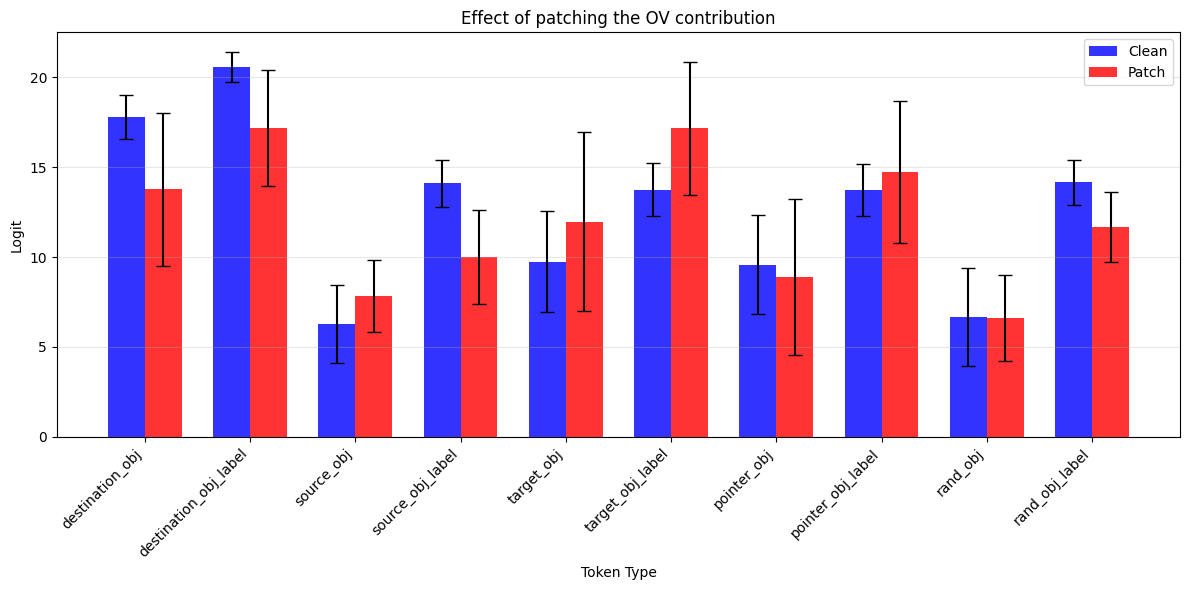

In [168]:
import numpy as np
import matplotlib.pyplot as plt

# Extract logit data for each token type
token_types = list(scores_by_token_type.keys())
clean_logits_mean = []
clean_logits_std = []
patch_logits_mean = []
patch_logits_std = []

for token_type in token_types:
    clean_data = np.array(scores_by_token_type[token_type]["logit"]["clean"])
    patch_data = np.array(scores_by_token_type[token_type]["logit"]["patch"])
    
    clean_logits_mean.append(clean_data.mean())
    clean_logits_std.append(clean_data.std())
    patch_logits_mean.append(patch_data.mean())
    patch_logits_std.append(patch_data.std())

# Set up the bar chart
x = np.arange(len(token_types))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
bars1 = ax.bar(x - width/2, clean_logits_mean, width, 
               yerr=clean_logits_std, label='Clean', 
               capsize=5, alpha=0.8, color='blue')
bars2 = ax.bar(x + width/2, patch_logits_mean, width, 
               yerr=patch_logits_std, label='Patch', 
               capsize=5, alpha=0.8, color='red')

# Customize the chart
ax.set_xlabel('Token Type')
ax.set_ylabel('Logit')
ax.set_title('Effect of patching the OV contribution')
ax.set_xticks(x)
ax.set_xticklabels(token_types, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [171]:
passed = 0
for result in ov_patching_results:
    track_tokens = result["track_tokens"]
    # target_tokens = [track_tokens["target_obj_label"], track_tokens["target_obj"]]
    target_tokens = [track_tokens["pointer_obj_label"], track_tokens["pointer_obj"]]

    patched_track = result["patched_track"]
    if (
        patched_track[list(patched_track.keys())[0]][1].token_id in target_tokens
    ):
        passed += 1

causality = passed / len(ov_patching_results)
print(f"Causality = {causality:.3f} ({passed}/{len(ov_patching_results)})",)

Causality = 0.139 (71/512)


## Effect of patching Q proj

In [69]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

destination, source = validation_set[37]
print("source:", source.prompt(), ">>", source.obj, ">>", mt.tokenizer.decode([source.ans_token_id]))
print("destination:", destination.prompt(), ">>", destination.obj, ">>", mt.tokenizer.decode([destination.ans_token_id]))

source: a. Tony Finau
b. Martin Scorsese
c. Denzel Washington
d. Bill Gates
e. James Patterson
Who among these people mentioned above is a actor by profession?
Answer: >> Denzel Washington >>  c
destination: p. Mark Zuckerberg
q. Petra Kvitová
r. Dave Chappelle
s. Julia Roberts
t. Anne Applebaum
Who among these people mentioned above is a entrepreneur by profession?
Answer: >> Mark Zuckerberg >>  p


In [71]:
validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=destination,
    patch_sample=source,
    heads=heads_selected["predicate"],
    verify_head_behavior_on = -1
)

2025-10-20 15:19:32 src.selection.optimization INFO     Verifying head behavior...
2025-10-20 15:19:32 src.selection.optimization INFO     Clean Sample >> Ans:  p


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-10-20 15:19:35 src.selection.functional DEBUG    Generated full answer: " p. Mark Zuckerberg
Mark Zuckerberg is a well-known entrepreneur and the co-founder and CEO of Facebook, a social media platform. He is also known"
2025-10-20 15:19:36 src.selection.functional DEBUG    Predictions: ['" p"[281] (p=0.633, logit=21.375)', '" ("[320] (p=0.160, logit=20.000)', '" Mark"[4488] (p=0.141, logit=19.875)', '" The"[578] (p=0.013, logit=17.500)', '" Option"[7104] (p=0.012, logit=17.375)']
2025-10-20 15:19:36 src.selection.functional INFO     Combined attention matrix for all heads


2025-10-20 15:19:36 src.selection.optimization INFO     Patch Sample >> Ans:  c


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-10-20 15:19:39 src.selection.functional DEBUG    Generated full answer: " c. Denzel Washington
Denzel Washington is an American actor, director, and producer. He has appeared in a wide range of films,"
2025-10-20 15:19:40 src.selection.functional DEBUG    Predictions: ['" c"[272] (p=0.770, logit=21.375)', '" ("[320] (p=0.081, logit=19.125)', '" Den"[9973] (p=0.038, logit=18.375)', '" Option"[7104] (p=0.018, logit=17.625)', '" The"[578] (p=0.016, logit=17.500)']
2025-10-20 15:19:40 src.selection.functional INFO     Combined attention matrix for all heads


2025-10-20 15:19:40 src.selection.optimization INFO     Caching the query states for the 101 heads
2025-10-20 15:19:40 src.selection.optimization INFO     patch_prediction=['" c"[272] (p=0.770, logit=21.375)', '" ("[320] (p=0.081, logit=19.125)', '" Den"[9973] (p=0.038, logit=18.375)', '" Option"[7104] (p=0.018, logit=17.625)', '" The"[578] (p=0.016, logit=17.500)']
2025-10-20 15:19:40 src.selection.optimization INFO     clean run
2025-10-20 15:19:40 src.selection.optimization INFO     clean_prediction=['" p"[281] (p=0.633, logit=21.375)', '" ("[320] (p=0.160, logit=20.000)', '" Mark"[4488] (p=0.141, logit=19.875)', '" The"[578] (p=0.013, logit=17.500)', '" Option"[7104] (p=0.012, logit=17.375)']
2025-10-20 15:19:40 src.selection.optimization INFO     clean_track=OrderedDict([(281, (1, PredictedToken(token=' p', prob=0.6328125, logit=21.375, token_id=281, metadata=None))), (272, (14, PredictedToken(token=' c', prob=0.00078582763671875, logit=14.6875, token_id=272, metadata=None))), (28

2025-10-20 15:19:40 src.selection.optimization INFO     int_prediction=['" s"[274] (p=0.555, logit=21.125)', '" d"[294] (p=0.124, logit=19.625)', '" ("[320] (p=0.109, logit=19.500)', '" Mark"[4488] (p=0.096, logit=19.375)', '" r"[436] (p=0.040, logit=18.500)']
2025-10-20 15:19:40 src.selection.optimization INFO     int_track=OrderedDict([(274, (1, PredictedToken(token=' s', prob=0.5546875, logit=21.125, token_id=274, metadata=None))), (436, (5, PredictedToken(token=' r', prob=0.0400390625, logit=18.5, token_id=436, metadata=None))), (281, (9, PredictedToken(token=' p', prob=0.004791259765625, logit=16.375, token_id=281, metadata=None))), (272, (26, PredictedToken(token=' c', prob=0.000347137451171875, logit=13.75, token_id=272, metadata=None))), (2874, (30, PredictedToken(token=' q', prob=0.0003070831298828125, logit=13.625, token_id=2874, metadata=None))), (259, (43, PredictedToken(token=' t', prob=0.0001277923583984375, logit=12.75, token_id=259, metadata=None)))])


{'clean_sample': SelectionSample(obj='Mark Zuckerberg', obj_idx=0, prompt_template='<_options_>\nWho among these people mentioned above is a <_category_> by profession?\nAnswer:', options=['Mark Zuckerberg', 'Petra Kvitová', 'Dave Chappelle', 'Julia Roberts', 'Anne Applebaum'], answer='Mark Zuckerberg', subj='Jack Ma', category='entrepreneur', prediction=[PredictedToken(token=' Mark', prob=0.8828125, logit=21.625, token_id=4488, metadata=None), PredictedToken(token=' The', prob=0.0439453125, logit=18.625, token_id=578, metadata=None), PredictedToken(token=' Among', prob=0.0302734375, logit=18.25, token_id=22395, metadata=None), PredictedToken(token=' (', prob=0.0142822265625, logit=17.5, token_id=320, metadata=None), PredictedToken(token=' Only', prob=0.0031890869140625, logit=16.0, token_id=8442, metadata=None)], ans_token_id=281, metadata={'track_category': 'actor', 'track_type_obj': 'Julia Roberts', 'track_type_obj_idx': 3, 'track_type_obj_token_id': 274, 'ques_pos': 34, 'tokenized'

In [132]:
# set difference
# len(sorted(list(set(heads_selected["predicate"]) - set(heads_selected["pointer"]))))
len(sorted(list(set(heads_selected["pointer"]) - set(heads_selected["predicate"]))))

# set union
# len(sorted(list(set(heads_selected["predicate"] + heads_selected["pointer"]))))

# set intersection
# len(sorted(list(set(heads_selected["predicate"]) & set(heads_selected["pointer"]))))

22

In [133]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
from tqdm.auto import tqdm

q_proj_patching_results = []
for destination, source in tqdm(validation_set):
    rand_idx = random.choice(
        list(set(range(len(destination.options))) - {source.obj_idx, destination.obj_idx, destination.metadata["track_type_obj_idx"]})
    )
    track_tokens = {
        "destination_obj": get_first_token_id(name=destination.obj, tokenizer=mt.tokenizer, prefix=" "),
        "destination_obj_label": destination.ans_token_id,
        "source_obj": get_first_token_id(name=source.obj, tokenizer=mt.tokenizer, prefix=" "),
        "source_obj_label": source.ans_token_id,
        "target_obj": get_first_token_id(name=destination.metadata["track_type_obj"], tokenizer=mt.tokenizer, prefix=" "),
        "target_obj_label": destination.metadata["track_type_obj_token_id"],
        # pointer
        "pointer_obj": get_first_token_id(name=destination.options[source.obj_idx], tokenizer=mt.tokenizer, prefix=" "),
        "pointer_obj_label": get_first_token_id(name=chr(ord(destination.option_label_start_from) + source.obj_idx), tokenizer=mt.tokenizer, prefix=" "),
        # random distractor
        "rand_obj": get_first_token_id(name=source.options[rand_idx], tokenizer=mt.tokenizer, prefix=" "),
        "rand_obj_label": get_first_token_id(name=chr(ord(source.option_label_start_from) + rand_idx), tokenizer=mt.tokenizer, prefix=" "),
    }

    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=destination,
        patch_sample=source,
        # heads=heads_selected["predicate"],
        # heads=sorted(list(set(heads_selected["predicate"]) - set(heads_selected["pointer"]))),
        # heads=sorted(list(set(heads_selected["predicate"] + heads_selected["pointer"]))),
        # heads=sorted(list(set(heads_selected["predicate"]) & set(heads_selected["pointer"]))),
        
        # heads=heads_selected["pointer"],
        heads=sorted(list(set(heads_selected["pointer"]) - set(heads_selected["predicate"]))),
        query_indices={-1: -1},
        add_ques_pos_to_query_indices=False,
        must_track_tokens=list(track_tokens.values()),
        # patch_args = {
        #     "batch_size": len(source.options) + 1,
        #     "distinct_options": False,
        # }
    )

    q_proj_patching_results.append(
        {
            "destination": destination,
            "source": source,
            "patched_pred": result["int_predictions"],
            "patched_track": result["int_track"],
            "destination_pred": result["clean_predictions"],
            "destination_track": result["clean_track"],
            "track_tokens": track_tokens,
        }
    )

  0%|          | 0/392 [00:00<?, ?it/s]

2025-10-20 17:00:49 src.selection.optimization INFO     Caching the query states for the 22 heads


2025-10-20 17:00:49 src.selection.optimization INFO     patch_prediction=['" f"[282] (p=0.469, logit=20.500)', '" ("[320] (p=0.222, logit=19.750)', '" James"[7957] (p=0.173, logit=19.500)', '" The"[578] (p=0.039, logit=18.000)', '" Option"[7104] (p=0.023, logit=17.500)']
2025-10-20 17:00:49 src.selection.optimization INFO     clean run
2025-10-20 17:00:49 src.selection.optimization INFO     clean_prediction=['" s"[274] (p=0.699, logit=21.125)', '" Robin"[17582] (p=0.107, logit=19.250)', '" ("[320] (p=0.095, logit=19.125)', '" The"[578] (p=0.031, logit=18.000)', '" Among"[22395] (p=0.015, logit=17.250)']
2025-10-20 17:00:49 src.selection.optimization INFO     clean_track=OrderedDict([(274, (1, PredictedToken(token=' s', prob=0.69921875, logit=21.125, token_id=274, metadata=None))), (17582, (2, PredictedToken(token=' Robin', prob=0.107421875, logit=19.25, token_id=17582, metadata=None))), (281, (10, PredictedToken(token=' p', prob=0.0019683837890625, logit=15.25, token_id=281, metadata=N

In [135]:
passed = 0
for result in q_proj_patching_results:
    track_tokens = result["track_tokens"]
    target_tokens = [track_tokens["target_obj_label"], track_tokens["target_obj"]]
    # target_tokens = [track_tokens["pointer_obj_label"], track_tokens["pointer_obj"]]

    patched_track = result["patched_track"]
    if (
        patched_track[list(patched_track.keys())[0]][1].token_id in target_tokens
    ):
        passed += 1

causality = passed / len(q_proj_patching_results)
print(f"Causality = {causality:.3f} ({passed}/{len(q_proj_patching_results)})",)

Causality = 0.181 (71/392)


In [136]:
import numpy as np

track_token_types = list(q_proj_patching_results[0]["track_tokens"].keys())
scores_by_token_type = {token_type: {} for token_type in track_token_types}

for token_type in track_token_types:
    print(f"{token_type}")
    ranks = {"clean": [], "patch": []}
    logits = {"clean": [], "patch": []}
    for result in q_proj_patching_results:
        target_tok_id = result["track_tokens"][token_type]
        clean_rank, clean_pred = result["destination_track"][target_tok_id]
        # logger.info(f"{target_tok_id=} | {result['patched_track'].keys()=}")
        patch_rank, patch_pred = result["patched_track"][target_tok_id]
        ranks["clean"].append(clean_rank)
        ranks["patch"].append(patch_rank)
        logits["clean"].append(clean_pred.logit)
        logits["patch"].append(patch_pred.logit)

    attr = {
        "rank": ranks,
        "logit": logits,
    }

    scores_by_token_type[token_type] = attr
    for target_concept in attr:
        clean = np.array(attr[target_concept]["clean"])
        patch = np.array(attr[target_concept]["patch"])
        delta = patch - clean
        print(f"{target_concept}: clean {clean.mean():.2f} ± {clean.std():.2f} -> patch {patch.mean():.2f} ± {patch.std():.2f} | delta {delta.mean():.2f} ± {delta.std():.2f}")
    

destination_obj
rank: clean 2.71 ± 0.92 -> patch 4.88 ± 4.00 | delta 2.16 ± 3.75
logit: clean 19.16 ± 1.02 -> patch 17.63 ± 1.40 | delta -1.53 ± 1.21
destination_obj_label
rank: clean 1.06 ± 0.24 -> patch 4.40 ± 4.16 | delta 3.34 ± 4.14
logit: clean 20.79 ± 0.63 -> patch 17.95 ± 1.63 | delta -2.84 ± 1.62
source_obj
rank: clean 2966.93 ± 5382.09 -> patch 2769.40 ± 5241.38 | delta -197.54 ± 2354.10
logit: clean 7.09 ± 2.13 -> patch 7.08 ± 2.25 | delta -0.01 ± 0.67
source_obj_label
rank: clean 27.21 ± 34.21 -> patch 35.08 ± 39.15 | delta 7.87 ± 15.96
logit: clean 14.11 ± 1.53 -> patch 13.50 ± 1.56 | delta -0.61 ± 0.81
target_obj
rank: clean 213.62 ± 491.70 -> patch 157.96 ± 538.95 | delta -55.67 ± 543.30
logit: clean 11.36 ± 2.52 -> patch 12.81 ± 3.07 | delta 1.45 ± 2.59
target_obj_label
rank: clean 33.92 ± 24.87 -> patch 14.82 ± 16.76 | delta -19.10 ± 26.32
logit: clean 13.47 ± 1.60 -> patch 15.94 ± 2.63 | delta 2.46 ± 2.83
pointer_obj
rank: clean 246.04 ± 564.07 -> patch 224.04 ± 975.47

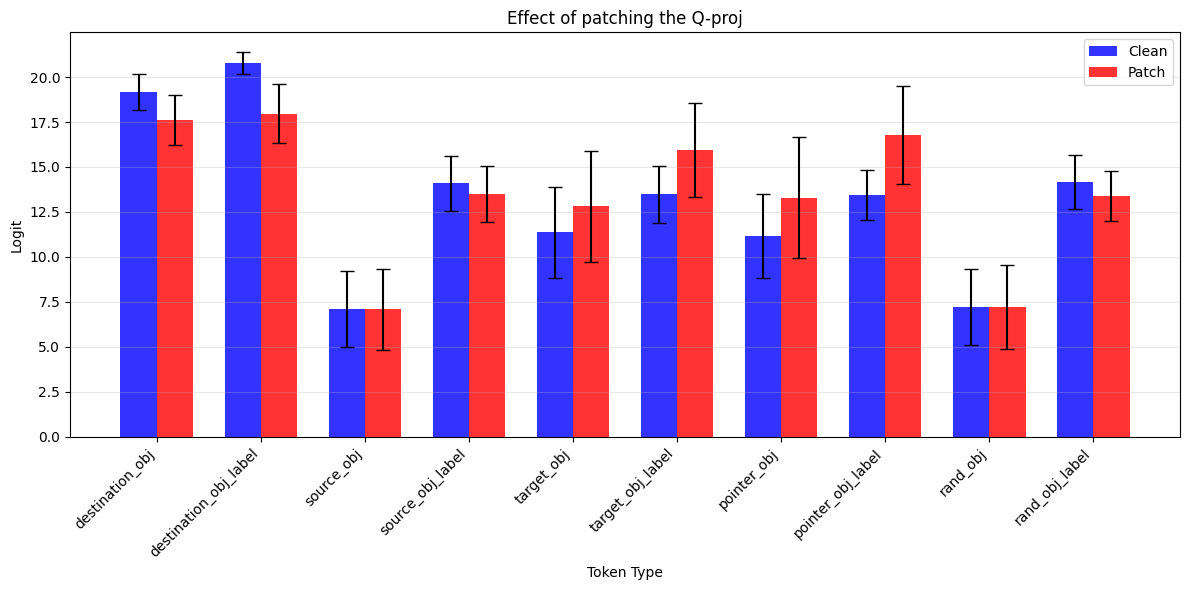

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Extract logit data for each token type
token_types = list(scores_by_token_type.keys())
clean_logits_mean = []
clean_logits_std = []
patch_logits_mean = []
patch_logits_std = []

for token_type in token_types:
    clean_data = np.array(scores_by_token_type[token_type]["logit"]["clean"])
    patch_data = np.array(scores_by_token_type[token_type]["logit"]["patch"])
    
    clean_logits_mean.append(clean_data.mean())
    clean_logits_std.append(clean_data.std())
    patch_logits_mean.append(patch_data.mean())
    patch_logits_std.append(patch_data.std())

# Set up the bar chart
x = np.arange(len(token_types))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
bars1 = ax.bar(x - width/2, clean_logits_mean, width, 
               yerr=clean_logits_std, label='Clean', 
               capsize=5, alpha=0.8, color='blue')
bars2 = ax.bar(x + width/2, patch_logits_mean, width, 
               yerr=patch_logits_std, label='Patch', 
               capsize=5, alpha=0.8, color='red')

# Customize the chart
ax.set_xlabel('Token Type')
ax.set_ylabel('Logit')
ax.set_title('Effect of patching the Q-proj')
ax.set_xticks(x)
ax.set_xticklabels(token_types, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()